#### This notebook demonstrates the use of adversarial debiasing algorithm to learn a fair classifier.
Adversarial debiasing [1] is an in-processing technique that learns a classifier to maximize prediction accuracy and simultaneously reduce an adversary's ability to determine the protected attribute from the predictions. This approach leads to a fair classifier as the predictions cannot carry any group discrimination information that the adversary can exploit. We will see how to use this algorithm for learning models with and without fairness constraints and apply them on the Adult dataset.

In [1]:
%load_ext autoreload
%autoreload 2


from aif360.algorithms.inprocessing.xgb_adversarial_debiasing import (
    XGBAdversarialDebiasing,
)
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import (
    load_preproc_data_german,
)
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from IPython.display import Markdown, display

2025-01-15 19:24:39.108217: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-15 19:24:39.111284: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-15 19:24:39.153231: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-15 19:24:39.153326: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-15 19:24:39.153350: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

#### Load dataset and set options

In [2]:
dataset_orig = load_preproc_data_german(["age", "sex"])
privileged_groups = [{"age": 1}]
unprivileged_groups = [{"age": 0}]

dataset_orig_train, dataset_orig_test = dataset_orig.split(
    [0.7], shuffle=True, seed=1234
)

In [3]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(
    dataset_orig_train.privileged_protected_attributes,
    dataset_orig_train.unprivileged_protected_attributes,
)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(700, 11)


#### Favorable and unfavorable labels

1.0 2.0


#### Protected attribute names

['age', 'sex']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['age', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed']


#### Metric for original training data

In [4]:
# Metric for the original dataset
metric_orig = BinaryLabelDatasetMetric(
    dataset_orig,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

display(Markdown("#### Original dataset"))
print(
    "Overall: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_orig.mean_difference()
)
# Metric for the training dataset

metric_orig_train = BinaryLabelDatasetMetric(
    dataset_orig_train,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)
display(Markdown("#### Original training dataset"))
print(
    "Train set: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_orig_train.mean_difference()
)
# Metric for the Test dataset

metric_orig_test = BinaryLabelDatasetMetric(
    dataset_orig_test,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)
print(
    "Test set: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_orig_test.mean_difference()
)

#### Original dataset

Overall: Difference in mean outcomes between unprivileged and privileged groups = -0.149448


#### Original training dataset

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.135639
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.183895


### Learn plan classifier without debiasing

In [5]:
tuning_settings = {
    "time_budget": 600,  # total running time in seconds
    "metric": "log_loss",
}   

In [6]:
plain_model = XGBAdversarialDebiasing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
    tune_hyperparameters=True,
    tuning_settings=tuning_settings,
    seed=1234,
    debias=False,
)

In [7]:
plain_model.fit(dataset_orig_train)

In [8]:
# Apply the plain model to test data
dataset_nodebiasing_train = plain_model.predict(dataset_orig_train)
dataset_nodebiasing_test = plain_model.predict(dataset_orig_test)

In [9]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
metric_dataset_nodebiasing_train = BinaryLabelDatasetMetric(
    dataset_nodebiasing_train,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

print(
    "Train set: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_dataset_nodebiasing_train.mean_difference()
)

metric_dataset_nodebiasing_test = BinaryLabelDatasetMetric(
    dataset_nodebiasing_test,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

print(
    "Test set: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_dataset_nodebiasing_test.mean_difference()
)

display(Markdown("#### Plain model - without debiasing - classification metrics"))
classified_metric_nodebiasing_test = ClassificationMetric(
    dataset_orig_test,
    dataset_nodebiasing_test,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)
print(
    "Test set: Classification accuracy = %f"
    % classified_metric_nodebiasing_test.accuracy()
)
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5 * (TPR + TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print(
    "Test set: Disparate impact = %f"
    % classified_metric_nodebiasing_test.disparate_impact()
)
print(
    "Test set: Equal opportunity difference = %f"
    % classified_metric_nodebiasing_test.equal_opportunity_difference()
)
print(
    "Test set: Average odds difference = %f"
    % classified_metric_nodebiasing_test.average_odds_difference()
)
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.240310
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.344262


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.733333
Test set: Balanced classification accuracy = 0.538404
Test set: Disparate impact = 0.655738
Test set: Equal opportunity difference = -0.305556
Test set: Average odds difference = -0.352778
Test set: Theil_index = 0.090440


### Apply in-processing algorithm based on adversarial learning

In [10]:
debiased_model = XGBAdversarialDebiasing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
    seed=1234,
    debias=True,
    tune_hyperparameters=True,
    tuning_settings=tuning_settings,
    adversary_loss_weight=1.0,
    debug=False,
)

In [11]:
dataset_orig_test.labels.shape

(300, 1)

In [12]:
def get_X_Y(dataset):
    X = dataset.features
    # Map the dataset labels to 0 and 1.
    temp_labels = dataset.labels.copy()

    temp_labels[(dataset.labels == dataset.favorable_label).ravel(), 0] = 1.0
    temp_labels[(dataset.labels == dataset.unfavorable_label).ravel(), 0] = 0.0
    Y = temp_labels
    return X, Y

In [13]:
X, Y = get_X_Y(dataset_orig_train)

In [14]:
debiased_model.fit(dataset=dataset_orig_train, test_dataset=dataset_orig_test)

In [15]:
# Apply the plain model to test data
dataset_debiasing_train = debiased_model.predict(dataset_orig_train)
dataset_debiasing_test = debiased_model.predict(dataset_orig_test)

In [16]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
print(
    "Train set: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_dataset_nodebiasing_train.mean_difference()
)
print(
    "Test set: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_dataset_nodebiasing_test.mean_difference()
)

# Metrics for the dataset from model with debiasing
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(
    dataset_debiasing_train,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

print(
    "Train set: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_dataset_debiasing_train.mean_difference()
)

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(
    dataset_debiasing_test,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

print(
    "Test set: Difference in mean outcomes between unprivileged and privileged groups = %f"
    % metric_dataset_debiasing_test.mean_difference()
)


display(Markdown("#### Plain model - without debiasing - classification metrics"))
print(
    "Test set: Classification accuracy = %f"
    % classified_metric_nodebiasing_test.accuracy()
)
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5 * (TPR + TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print(
    "Test set: Disparate impact = %f"
    % classified_metric_nodebiasing_test.disparate_impact()
)
print(
    "Test set: Equal opportunity difference = %f"
    % classified_metric_nodebiasing_test.equal_opportunity_difference()
)
print(
    "Test set: Average odds difference = %f"
    % classified_metric_nodebiasing_test.average_odds_difference()
)
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())


display(Markdown("#### Model - with debiasing - classification metrics"))
classified_metric_debiasing_test = ClassificationMetric(
    dataset_orig_test,
    dataset_debiasing_test,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)
print(
    "Test set: Classification accuracy = %f"
    % classified_metric_debiasing_test.accuracy()
)
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5 * (TPR + TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print(
    "Test set: Disparate impact = %f"
    % classified_metric_debiasing_test.disparate_impact()
)
print(
    "Test set: Equal opportunity difference = %f"
    % classified_metric_debiasing_test.equal_opportunity_difference()
)
print(
    "Test set: Average odds difference = %f"
    % classified_metric_debiasing_test.average_odds_difference()
)
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.240310
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.344262


#### Model - with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.009992
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.012895


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.733333
Test set: Balanced classification accuracy = 0.538404
Test set: Disparate impact = 0.655738
Test set: Equal opportunity difference = -0.305556
Test set: Average odds difference = -0.352778
Test set: Theil_index = 0.090440


#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.736667
Test set: Balanced classification accuracy = 0.516267
Test set: Disparate impact = 1.013284
Test set: Equal opportunity difference = -0.011562
Test set: Average odds difference = 0.031256
Test set: Theil_index = 0.067829


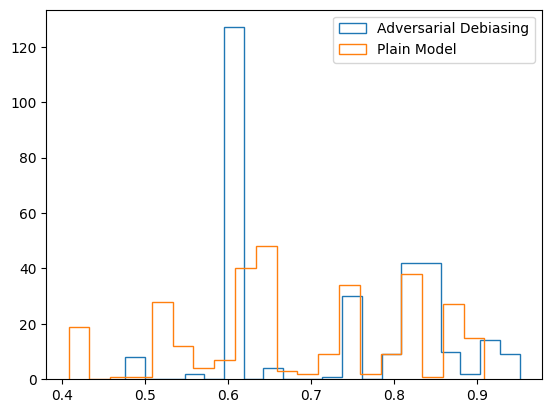

In [17]:
import matplotlib.pyplot as plt

bins = 20
probs_ad = debiased_model.predict_proba(dataset_orig_test)[:, 1]
base_probs = plain_model.predict_proba(dataset_orig_test)[:, 1]
# plt.hist(adjusted_probs, bins=bins, histtype="step", label="Fairness Adjuster")
plt.hist(probs_ad, bins=bins, histtype="step", label="Adversarial Debiasing")
plt.hist(base_probs, bins=bins, histtype="step", label="Plain Model")
plt.legend()
plt.show()

In [18]:
plain_model.estimator.best_config

{'n_estimators': 8,
 'max_leaves': 9,
 'min_child_weight': 9.232131954429383,
 'learning_rate': 0.8598978349396178,
 'subsample': 0.964593082343062,
 'colsample_bylevel': 0.40396500095162347,
 'colsample_bytree': 0.7477971102634645,
 'reg_alpha': 0.002247666139172512,
 'reg_lambda': 8.809520328961995}

In [19]:
debiased_model.estimator.best_config

{'n_estimators': 6,
 'max_leaves': 51,
 'min_child_weight': 0.0011074582449367685,
 'learning_rate': 1.0,
 'subsample': 0.1265743180611953,
 'colsample_bylevel': 0.30511523489779213,
 'colsample_bytree': 0.512839732159211,
 'reg_alpha': 0.010754817837047135,
 'reg_lambda': 0.013801863233242444}


    References:
    [1] B. H. Zhang, B. Lemoine, and M. Mitchell, "Mitigating UnwantedBiases with Adversarial Learning," 
    AAAI/ACM Conference on Artificial Intelligence, Ethics, and Society, 2018.